In [2]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from utils.mediapipe_cropper.cropper import process_images


Before starting with Exploratory Data Analysis (EDA), make you have downloaded the dataset:
https://www.kaggle.com/datasets/innominate817/hagrid-sample-30k-384p
And put it into shared_artifacts/images/hagrid_30k so that it contains train_val_call, train_val_dislike etc...

Next stage is to run the hand extraction tool, make sure you are using python 3.12
Navigate to the utils/mediapipe_cropper/ and run:
```bash
python3 cropper.py --input ../../shared_artifacts/images/hagrid_30k --output ../../shared_artifacts/images/hagrid_30k_cropped
```

In [ ]:
process_images('shared_artifacts/images/hagrid_30k', 'shared_artifacts/images/hagrid_30k_cropped')

libEGL warning: pci id for fd 100: 10de:1b81, driver (null)

pci id for fd 111: 10de:1b81, driver (null)
pci id for fd 112: 10de:1b81, driver (null)
libEGL warning: egl: failed to create dri2 screen
pci id for fd 111: 10de:1b81, driver (null)
pci id for fd 112: 10de:1b81, driver (null)
libEGL warning: egl: failed to create dri2 screen
I0000 00:00:1764869970.453146   28720 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764869970.467315   28827 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 25.2.7), renderer: llvmpipe (LLVM 21.1.5, 256 bits)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1764869970.500596   28830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764869970.529376   28828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedbac

FileNotFoundError: [Errno 2] No such file or directory: '../../shared_artifacts/images/hagrid_30k'

In [3]:
analysis_data = []
path = 'shared_artifacts/images/hagrid_30k_cropped'
extensions = ('.jpg')
corrupted_images = 0

for class_label in os.listdir(path):
    pure_label = class_label[10:] # removes 'train_val_' prefix
    label_path = os.path.join(path, class_label)

    if os.path.exists(label_path):
        files = os.listdir(label_path)

        image_files = [f for f in files if f.lower().endswith(extensions)]

        if len(files) != len(image_files):
            print(f"Warning: Some non-image (.jpg) files found in {label_path}")

        for image in image_files:
            image_path = os.path.join(label_path, image)

            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    type = img.mode # RGB, L, etc.
                    file_size = os.path.getsize(image_path) / 1024 # KB

                    analysis_data.append({
                        'filename': image,
                        'class': pure_label,
                        'width': width,
                        'height': height,
                        'aspect_ratio': round(width/height, 2),
                        'type': type,
                        'file_size_kb': round(file_size, 2),
                        'path': image_path
                    })
                
            except Exception as e:
                print(f"Error reading {image_path}: {e}")
                corrupted_images += 1

df = pd.DataFrame(analysis_data)

In [4]:
print(f"Total images: {len(df)}")
print(f"Number of classes: {df['class'].nunique()}")
print(f"Average aspect ratio: {df['aspect_ratio'].mean():.2f}")
print(f"Average dimensions: {df['width'].mean():.2f}x{df['height'].mean():.2f}")
print(f"Min dimensions: {df['width'].min()}x{df['height'].min()}")
print(f"Max dimensions: {df['width'].max()}x{df['height'].max()}")
print(f"Average file size: {df['file_size_kb'].mean():.2f} KB")
print(f"Corrupted images: {corrupted_images}")
print(f"Types present: {df['type'].unique()}")

Total images: 2594
Number of classes: 2
Average aspect ratio: 0.76
Average dimensions: 85.80x115.57
Min dimensions: 46x55
Max dimensions: 237x388
Average file size: 4.56 KB
Corrupted images: 0
Types present: ['RGB']


The information we have gathered so far:
- Total number of images is 31833
- Number of classes is 18
- Dimensions are ranging from 384x384 to 854x1007
- No corrupted images
- All images are in RGB format
- All files are .jpg

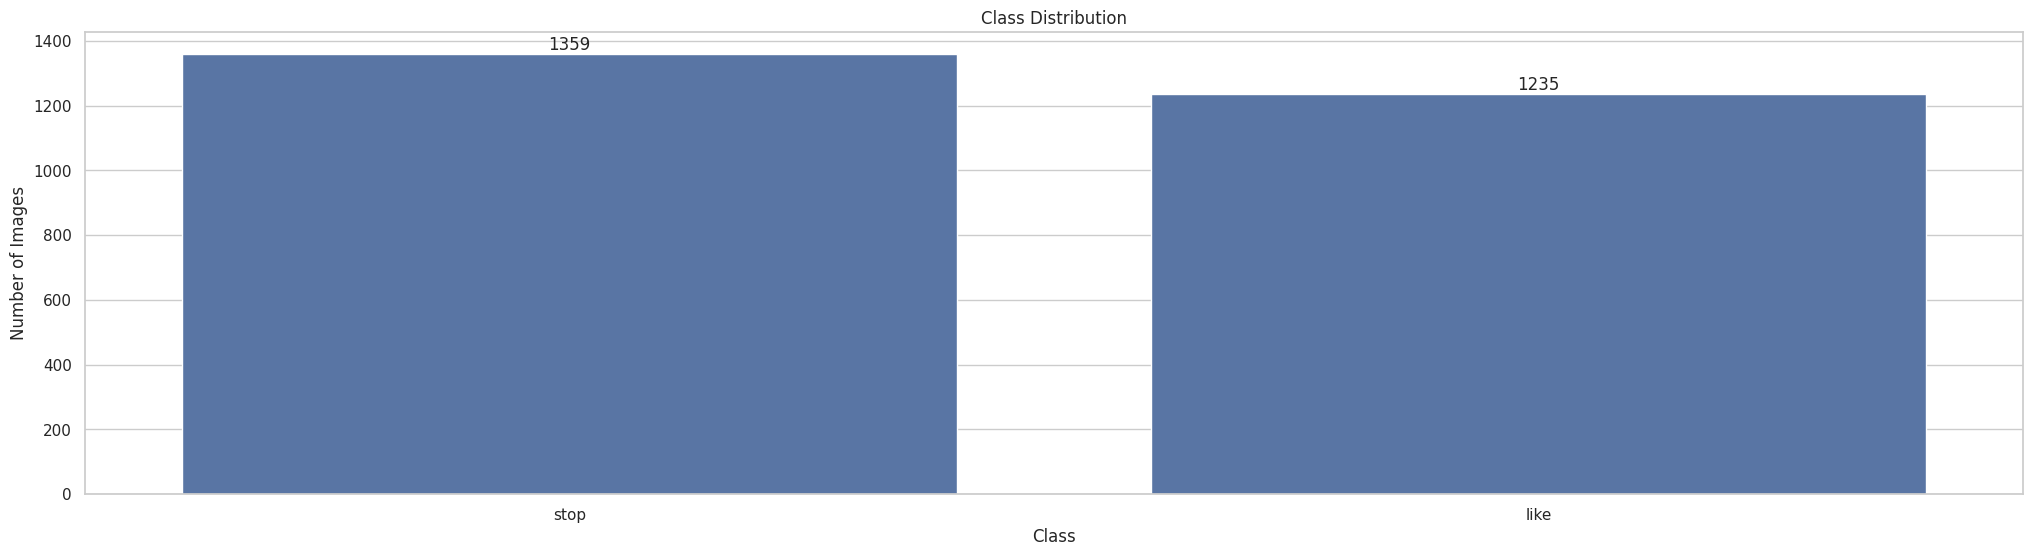

In [5]:
sns.set_theme(style="whitegrid")

# Class distribution
classes = df['class'].value_counts()
plt.figure(figsize=(25, 6))
barplot = sns.barplot(x=classes.index, y=classes.values)
barplot.bar_label(barplot.containers[0])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [6]:
# Dimension distribution
print(df[['width', 'height']].describe())
standard_mask = (df['width'] == 384) & (df['height'] == 512)
standard_mask_rotated = (df['width'] == 512) & (df['height'] == 384)
print(f"Standard (384×512): {standard_mask.sum()} images ({standard_mask.sum()/len(df)*100:.1f}%)")
print(f"Standard 2 (512×384): {standard_mask_rotated.sum()} images ({standard_mask_rotated.sum()/len(df)*100:.1f}%)")
print(f"Non-standard: {(~standard_mask & ~standard_mask_rotated).sum()} images ({(~standard_mask & ~standard_mask_rotated).sum()/len(df)*100:.1f}%)")

             width       height
count  2594.000000  2594.000000
mean     85.801465   115.572089
std      22.178645    35.341849
min      46.000000    55.000000
25%      71.000000    90.250000
50%      82.000000   108.500000
75%      95.000000   131.000000
max     237.000000   388.000000
Standard (384×512): 0 images (0.0%)
Standard 2 (512×384): 0 images (0.0%)
Non-standard: 2594 images (100.0%)


Lets take a look at sample images

['shared_artifacts/images/hagrid_30k_cropped/train_val_like/6e82b7b2-e576-456b-a578-d232dd952525.jpg', 'shared_artifacts/images/hagrid_30k_cropped/train_val_stop/3eaf245b-2bb9-4447-af5a-bfb3d07e9ee6.jpg']
2


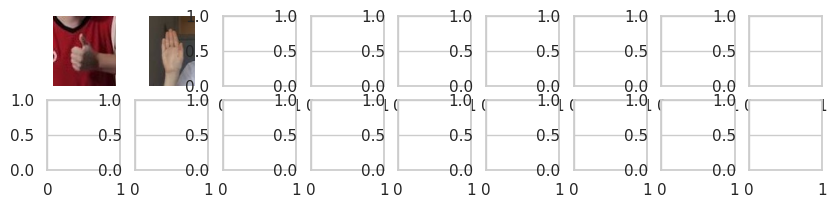

In [10]:
preview = []
for class_label in os.listdir(path):
    pure_label = class_label[10:] # removes 'train_val_' prefix
    label_path = os.path.join(path, class_label)

    if os.path.exists(label_path):
        files = os.listdir(label_path)

        image_files = [f for f in files if f.lower().endswith(extensions)]

        rand_idx = random.randint(0, len(image_files))
        preview.append(os.path.join(path, class_label, image_files[rand_idx]))

print(preview)
print(len(preview))

rows, cols = 2, 9

fig, axes = plt.subplots(rows, cols, figsize=(10,2))

for ax, image in zip(axes.flat, preview):
    with Image.open(image) as img:
        ax.imshow(img)
        ax.set_axis_off()
    
        

TO-DO: Sample images, proper attribution to the dataset